In [327]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import csv

In [328]:
#ESSENTIAL VARIABLES

# set the coordinates in tuple form of the polygon


#COORDINATES = [(1,0), (2,0), (3,1), (3,2), (2,3), (1,3), (0,2), (0,1)] # octagon
#COORDINATES = [(0,1), (1,0), (2,0), (3,1), (1.5,2)] # pentagon
#COORDINATES = [(1,10), (3, 8),(0,2), (1,1), (2,0), (3,0), (4,1), (5,2), (4,3), (3,4), (2,4), (1,3), (2,5), (6,7), (8,12), (4,4), (9,9), (4,6), (12,5), (1,6), (2, 7), (8,2), (9,4), (7,6)] # random
#COORDINATES = [(0,2), (1,1), (2,0), (3,0), (4,1), (5,2), (4,3), (3,4), (2,4), (1,3)] # decigon

with open('coordinates.csv', newline='') as f:
    reader = csv.reader(f)
    COORDINATES = list(reader)

for point in COORDINATES:
    point[0] = int(point[0])
    point[1] = int(point[1])


# number of children a parent births per run
# usually use 500
BIRTH_SIZE = 500

# number of children required to have the fittest distance before the final distance is determined
# higher = more accurate, but takes much more time, especially past 200
# usually use 100
NUM_FITTEST_CHILDREN = 100

"""
max. number of mutations per child.
seems as though the higher the number of coordinates gets, the mutation number has a greater effect.
however, too high, and computation time takes too long.
too low, it's less accurate.
3 seems to be the sweet spot
at lower numbers, the mutations per child don't seem to matter
# usually use 1 for small, 3 for large
"""
MUTATIONS_PER_CHILD = 3

In [329]:
def cross(parent_1, parent_2):
    child = []
    #print(f'asdf{len(parent_1)}')
    #print(len(parent_1), len(parent_2))
    parents = [parent_1, parent_2]
    for i in range(1, len(parent_1)):
        prob = random.randint(0, 1)
        opposite_prob = abs(prob - 1)
        if parents[prob][i] not in child:
            child.insert(i, parents[prob][i])
            
        elif parents[opposite_prob][i] not in child:
            child.insert(i, parents[opposite_prob][i])
            
        else:
            for x in range(1, len(parents[prob]) - 1):
                if parents[prob][x] not in child:
                    child.insert(i, parents[prob][x])
    child.insert(0, parents[0][0])
    #print(len(child))
    return child        

In [330]:


# finds distance covered from index 0 to last index, moving left to right
# doesn't return to original index (full circle), stops at last index
def find_dist(coords):
    # get previous value to compute distance
    # here, prev is the first coordinate of the list, but later becomes the i-1 th coordinate
    prev = coords[0]
    
    # distance variable for summation
    dist = 0
    
    # iterate over coordinates, add distances between coordinates to total distance, repeat until done
    for i in range(1, len(coords)):
        # distance formula: sqrt((x change)^2 + (y change)^2)
        temp_dist = np.sqrt(( np.square(( prev[0] - coords[i][0] )) + np.square( prev[1] - coords[i][1] )))
        
        dist += temp_dist
        prev = coords[i]
        
    # return distance covered float
    return dist

# switch two coordinates at random in the list
def mutate(child, mutations):
    # create copy to prevent accidental modifications
    temp_child = child.copy()
    
    # create random indices to swap
    indices_list = []
    for i in range(mutations):
        indices_list.append([random.randint(1, len(temp_child) - 1), random.randint(1, len(temp_child) - 1)])
    
    # swap the two coordinates
    for indices in indices_list:
        temp_gene = temp_child[indices[0]]
        temp_child[indices[0]] = temp_child[indices[1]]
        temp_child[indices[1]] = temp_gene

    # return the list with the swapped coordinates
    return temp_child

# create size number of mutated children, based on the parent
def reproduce(parents, pop_size):
    children = []

    for i in range(pop_size):
        children.append(mutate(cross(parents[0], parents[1]), MUTATIONS_PER_CHILD))
    
    return children
    
# choose best child from the population
def select(children):
    # find best performing child byu
    lowest = find_dist(children[0])
    second_lowest = find_dist(children[1])
    
    fittest_child = children[0]
    second_fittest_child = children[1]
    
    for i in range(2, len(children) - 1):
        child_distance = find_dist(children[i])
        
        if child_distance < lowest:
            lowest = child_distance
            fittest_child = children[i]
        elif child_distance < second_lowest:
            second_lowest = child_distance
            second_fittest_child = children[i]
            
    return [fittest_child, second_fittest_child]

In [331]:
# record time at beginning of execution

begin_time = time.time()

# shuffle the points, and insert the starting point into the beginning
# note: the starting point will never be "mutated," it will always remain at the first index
original_parents = [COORDINATES[1:], COORDINATES[1:]]

random.shuffle(original_parents[0])
random.shuffle(original_parents[1])

original_parents[0].insert(0, COORDINATES[0])
original_parents[1].insert(0, COORDINATES[0])


# set the fittest parent equal to the original parent initially
fittest_children = original_parents.copy()

# set the last parent equal to the original parent initially
last_parents = fittest_children.copy()

# sequence list for animation export

parent_dist = [100000000, 100000000]
count = 0
# run until the "best" distance is found count times, to ensure the children really are close to the fittest
fittest_found = False
while not fittest_found:
    # create children based off the mother with a birth size of BIRTH_SIZE
    members = reproduce(last_parents, BIRTH_SIZE)
    
    # choose the fittest child, which becomes the parent of the next generation
    fittest_child = select(members)
    
    # find the distance traveled of the fittest child
    child_dist = [find_dist(fittest_child[0]), find_dist(fittest_child[1])]

    
    # if the child is fitter than the parent, replace the parent with the child
    for i in range(len(child_dist) - 1):
        if child_dist[i] < parent_dist[0]:
            count = 0
            print(f'\nNew fittest distance: {child_dist[i]}')
            parent_dist[0] = child_dist[i]
           # print(len(fittest_child[i]))
            #print(len(fittest_child[0]))
            last_parents[0] = fittest_child[i]
            
        elif child_dist[i] < parent_dist[1]:
            count = 0
            print(f'\nNew fittest distance: {child_dist[i]}')
            parent_dist[1] = child_dist[i]
            last_parents[1] = fittest_child[i]
            
        elif child_dist[i] == parent_dist[0] or child_dist[i] == parent_dist[0]:
            print(f'{count}/{NUM_FITTEST_CHILDREN} equivalents found')
            count += 1
            if count >= NUM_FITTEST_CHILDREN:
                fittest_found = True

end_time = time.time()
time_diff = end_time - begin_time


New fittest distance: 624.0880131772045

New fittest distance: 563.9356575298727

New fittest distance: 551.6796221206201

New fittest distance: 536.6268857714396

New fittest distance: 465.7101663570973

New fittest distance: 477.5195256184852

New fittest distance: 469.7657581318308

New fittest distance: 440.87210543275404

New fittest distance: 422.7812502552402

New fittest distance: 415.9522626345249

New fittest distance: 404.76025063299977

New fittest distance: 406.565441173374

New fittest distance: 325.2693011257226

New fittest distance: 339.41080144322706

New fittest distance: 305.87354869703745

New fittest distance: 309.2845019742807

New fittest distance: 307.849050470231

New fittest distance: 278.1999805062528

New fittest distance: 301.72265898482345

New fittest distance: 276.0381841413474

New fittest distance: 291.95586321685073

New fittest distance: 287.95127320367806

New fittest distance: 287.4098551812304

New fittest distance: 274.53304863456947

New fitte

Start Point:[25, 0]

GA's Best Sequence[[25, 0], [19, 1], [1, 17], [0, 23], [0, 30], [2, 36], [6, 41], [10, 45], [16, 48], [22, 50], [28, 50], [34, 48], [40, 45], [44, 41], [48, 36], [50, 30], [50, 23], [49, 17], [46, 12], [42, 7], [37, 3], [31, 1], [13, 3], [8, 7], [4, 12]]
GA's Best Distance: 181.0448373098638

Original Sequence:[[25, 0], [42, 7], [34, 48], [0, 23], [44, 41], [10, 45], [13, 3], [16, 48], [50, 30], [4, 12], [50, 23], [31, 1], [19, 1], [49, 17], [22, 50], [46, 12], [48, 36], [2, 36], [6, 41], [37, 3], [40, 45], [0, 30], [8, 7], [28, 50], [1, 17]]
Original Distance: 893.9234346603205

Percent Improvement:79.74716510495571%

Execution Time: 63.17030358314514 seconds


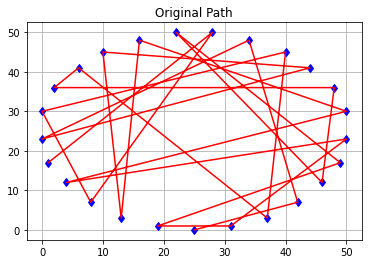

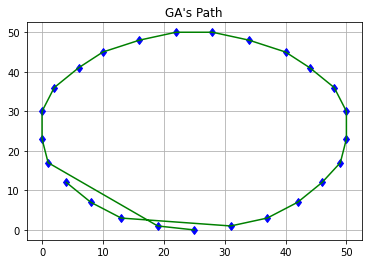

In [332]:
# OUTPUT FINAL DATA
# information about old sequence of coordinates, then GA's sequence
print("Start Point:" + str(original_parents[0][0]) + "\n")
print("GA's Best Sequence" + str(last_parents[0]))
print("GA's Best Distance: " + str(find_dist(last_parents[0])) + "\n")

print("Original Sequence:" + str(original_parents[0]))
print("Original Distance: " + str(find_dist(original_parents[0])) + "\n")

pct_change = ( find_dist(original_parents[0]) - find_dist(last_parents[0]) )/ find_dist(original_parents[0]) * 100
print("Percent Improvement:" + str(pct_change) + "%\n")

print("Execution Time: " + str(time_diff) + " seconds")
# charts of old sequence vs GA's sequence
x, y = np.array(original_parents[0]).T
x_path, y_path = np.array(last_parents[0]).T

plt.title("Original Path")
plt.plot(x, y, "bd")
plt.plot(x, y, "r")
plt.grid()
plt.show()

plt.title("GA's Path")
plt.plot(x_path, y_path, "bd")
plt.plot(x_path, y_path, "g")
plt.grid()
plt.show()